In [43]:
# from google.colab import drive
# drive.mount('/content/drive')

In [44]:
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yfinance as yf
from collections import deque
import matplotlib.pyplot as plt

### Data Preparation

In [ ]:
tickers = ["AAPL", "MSFT", "GOOGL", "SBUX", "TSLA"]
# tickers = ["GME", "AMC", "SPCE", "NVAX", "NOK"]

# Date range for historical data
start_date = "2014-01-01"
end_date   = "2023-12-31"

data_file = "prices.csv"
try:
    prices_df = pd.read_csv(data_file, index_col=0, parse_dates=True)
    print("Loaded data from", data_file)
except FileNotFoundError:
    print("Downloading price data for tickers:", tickers)
    df = yf.download(tickers, start=start_date, end=end_date, interval="1d")
    # Extract the 'Close' prices from the MultiIndex DataFrame
    prices_df = df.xs('Close', axis=1, level='Price')
    prices_df.dropna(inplace=True)
    prices_df.to_csv(data_file)
    print("Data downloaded and saved to", data_file)

# Split data into training (first 4 years) and testing (last year)
full_train_df = prices_df[prices_df.index < "2023-01-01"]
test_df  = prices_df[prices_df.index >= "2023-01-01"]
full_train_prices = full_train_df.values  # shape: [train_days, 5]
test_prices  = test_df.values   # shape: [test_days, 5]
num_assets = full_train_prices.shape[1]
print(f"Training days: {full_train_prices.shape[0]}, Testing days: {test_prices.shape[0]}")

# Further split full training into training and validation (80/20)
split_index = int(0.8 * full_train_prices.shape[0])
train_prices = full_train_prices[:split_index]
val_prices   = full_train_prices[split_index:]

Loaded data from prices.csv
Training days: 2266, Testing days: 250


###  Technical Indicators & State Representation

In [ ]:
def get_market_indicators(price_array, t, window=10):
    """
    Compute technical indicators for each asset at time t:
      - Moving Average Ratio: current price / moving average over window
      - Volatility: std dev of daily returns over window (normalized by current price)
    If not enough history exists, use current price and low volatility.
    Returns a list of 2 values per asset.
    """
    indicators = []
    for asset in range(num_assets):
        if t < window:
            moving_avg_ratio = 1.0
            vol = 0.0
        else:
            window_prices = price_array[t-window+1:t+1, asset]
            moving_avg = np.mean(window_prices)
            moving_avg_ratio = price_array[t, asset] / (moving_avg + 1e-6)
            returns = np.diff(window_prices) / (window_prices[:-1] + 1e-6)
            vol = np.std(returns) / (price_array[t, asset] + 1e-6)
        indicators.extend([moving_avg_ratio, vol])
    return indicators

def get_state(t, alloc_state, price_array):
    """
    Constructs the state vector at time t by combining:
      - Portfolio allocations (6 numbers: 5 assets + cash) normalized to [0,1]
      - Market indicators for assets (2 per asset)
    Returns a numpy array of length 6 + 10 = 16.
    """
    alloc_norm = [a / 100.0 for a in alloc_state]
    indicators = get_market_indicators(price_array, t)
    return np.array(alloc_norm + indicators)

### State Encoding/Decoding and Actions

In [ ]:
# Construct the new action space.
# Each action is a tuple (src, dst, amt) where:
# - src and dst are indices in assets_plus_cash (0..5)
# - amt is in [1, 2, 3, 4, 5] representing a 1%-5% transfer.
# We allow transferring funds between any two different assets.

# Define all possible actions (including no-action) as tuples
all_actions = []
cash_idx = num_assets            # index 5 is for cash
assets_plus_cash = list(range(num_assets)) + [cash_idx]  # [0,1,2,3,4,5]
percents = [1,2,3,4,5]
for pct in percents:
    for src in assets_plus_cash:
        for dst in assets_plus_cash:
            if src != dst:
                all_actions.append((src, dst, pct))
all_actions.append((None, None, 0))  # No action
action_count = len(all_actions) # 151

# Create a mapping from action tuple to index in all_actions list
action_to_index = {act: idx for idx, act in enumerate(all_actions)}

def get_valid_actions(state):
    """
    Given a state (tuple of 6 integers summing to 100 representing allocations for 5 stocks and cash),
    return a list of valid actions (from all_actions_new).
    
    Rules:
      - If src is not cash, state[src] must be >= amt (i.e. you must have enough allocation to sell).
      - Optionally, we can restrict that if dst is not cash, the allocation after transfer should not exceed 100.
        (Here we assume no single asset can have more than 100%).
      - The no-action (None, None, 0) is always valid.
    """
    valid = []
    for act in all_actions:
        if act == (None, None, 0):
            valid.append(act)
        else:
            src, dst, amt = act
            if src != cash_idx and state[src] < amt:
                continue
            if dst != cash_idx and state[dst] + amt > 100:
                continue
            valid.append(act)
    return valid


def apply_action(state, action):
    """
    Apply an action (src, dst, amt) to the state.
    - state: tuple of 6 integers (allocations in % for 5 stocks and cash; sum to 100)
    - action: (src, dst, amt). For example, (0,5,3) means transfer 3% from asset 0 to cash.
      (None, None, 0) means no action.
    Returns the new state as a tuple of 6 integers.
    """
    state = list(state)
    if action == (None, None, 0):
        return tuple(state)
    src, dst, amt = action
   
    if src is not None and state[src] >= amt:
        state[src] = state[src] - amt
    if dst is not None and dst != cash_idx and state[dst] + amt <= 100:
        state[dst] = state[dst] + amt
    if dst == cash_idx:
        state[cash_idx] = state[cash_idx] + amt
    total = sum(state)
    state = [100 * x / total for x in state]
    return tuple(state)

### Reward Shaping using a Rolling Sharpe Ratio

In [ ]:
class SharpeRewardShaper:
    def __init__(self, window=30, epsilon=1e-6):
        self.window = window
        self.rewards_history = []
        self.epsilon = epsilon
        self.portfolio_max = -np.inf

    def shape(self, raw_reward, current_portfolio):
        """
        Enhances reward by:
          - Computing rolling Sharpe ratio,
          - Penalizing drawdowns (if current_portfolio is lower than past peak),
          - Penalizing high volatility.
        """
        self.rewards_history.append(raw_reward)
        if len(self.rewards_history) > self.window:
            self.rewards_history.pop(0)
        avg_reward = np.mean(self.rewards_history)
        std_reward = np.std(self.rewards_history) + self.epsilon
        sharpe = avg_reward / std_reward

        # Update running maximum portfolio value
        self.portfolio_max = max(self.portfolio_max, current_portfolio)
        drawdown = (self.portfolio_max - current_portfolio) / (self.portfolio_max + self.epsilon)
        drawdown_penalty = drawdown * 0.5  # factor can be tuned

        # Volatility penalty: higher volatility (std reward) reduces reward
        vol_penalty = std_reward * 0.5  # factor can be tuned

        # Final shaped reward: encourage long term gain via n-step (raw_reward already multi-step) + penalize risks
        shaped_reward = sharpe - drawdown_penalty - vol_penalty

        return shaped_reward

def compute_reward(weights_frac, price_array, t, n_step=3):
    """
    Compute the reward using n-step return from time t to t+n_step.
    Growth is computed by taking the weighted sum of asset returns over n_step days.
    If t+n_step is beyond available data, use last available day.
    """
    last_index = min(t + n_step, price_array.shape[0] - 1)
    growth_factor = 0.0
    for k in range(len(assets_plus_cash)):
        if k == cash_idx:
            ratio = 1.0
        else:
            ratio = price_array[last_index, k] / (price_array[t, k] + 1e-9)
        growth_factor += weights_frac[k] * ratio
    # raw reward is log of multi-step growth factor
    return math.log(growth_factor + 1e-6)

reward_shaper = SharpeRewardShaper(window=30)

### Replay Buffer for Experience Replay

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        """
        Replay buffer to store past transitions for experience replay.
        Stores tuples of (state, action_index, reward, next_state, done).
        """
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action_idx, reward, next_state, done):
        """Save a transition to the buffer."""
        self.buffer.append((state, action_idx, reward, next_state, done))

    def sample(self, batch_size):
        """
        Sample a random batch of transitions from the buffer.
        Returns: tuples (states, action_idxs, rewards, next_states, dones) for the batch.
        """
        batch = random.sample(self.buffer, batch_size)
        states, action_idxs, rewards, next_states, dones = zip(*batch)
        return list(states), list(action_idxs), list(rewards), list(next_states), list(dones)

    def __len__(self):
        """Current size of the buffer."""
        return len(self.buffer)

### Neural Network for Q-value Function

In [ ]:
class DQNNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        """
        Neural network that approximates Q(s,a) for all actions a given state s.
        state_dim: dimensionality of state input (e.g. 5)
        action_dim: number of possible actions (e.g. 21)
        """
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.ln1 = nn.LayerNorm(128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 256)
        self.ln2 = nn.LayerNorm(256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        q_vals = self.fc4(x)

        return q_vals

### DQN Agent Training Setup

In [ ]:
# Hyperparameters
use_double_dqn = True  # use Double DQN for      
state_dim = num_assets + 1 + num_assets * 2  # 6 (allocations) + 10 (2 indicators per each of the 5 assets) = 16
initial_state=(20, 20, 20, 20, 20, 0)
# For action selection and training, we take the average Q-values across ensemble members.
def ensemble_q_values(state_input, nets):
    original_modes = [net.training for net in nets]

    # Switch networks to eval mode for inference (to avoid BN issues with batch size 1)
    for net in nets:
        net.eval()

    # Compute Q-values from each network and average them
    q_vals_list = [net(state_input) for net in nets]  # shape: [ensemble_size, batch, action_dim]
    avg_q_vals = torch.stack(q_vals_list, dim=0).mean(dim=0)

    # Restore the original training mode of each network
    for net, mode in zip(nets, original_modes):
        if mode:
            net.train()
        else:
            net.eval()

    return avg_q_vals

def select_action(state, t, train_prices, epsilon, nets, temperature = 1.0):
    """
    Hybrid exploration:
      - With probability epsilon, choose a random valid action.
      - Otherwise, use Boltzmann sampling (softmax over Q-values for valid actions).
    The state passed in is the portfolio allocation (tuple of 6 ints).
    We combine it with market indicators computed from price_array at time t.
    Returns: (action_idx, action_tuple)
    """
    valid_actions = get_valid_actions(state)
    if random.random() < epsilon:
        # Exploration: random valid action
        action = random.choice(valid_actions)
    else:
        # Exploitation: choose best action according to Q-network
        # Normalize state: now state values are percentages out of 100
        state_vec = get_state(t, state, train_prices)
        state_tensor = torch.FloatTensor(state_vec).unsqueeze(0)
        with torch.no_grad():
          q_values = ensemble_q_values(state_tensor, nets)  # shape [1, action_count]
          q_values = q_values.numpy().squeeze()  # shape [action_count]
        # Mask out invalid actions by setting their Q-value very low
        # (So they won't be chosen as max)
        invalid_actions = set(all_actions) - set(valid_actions)
        for act in invalid_actions:
            # if act in action_to_index:
            q_values[action_to_index[act]] = -1e9  # large negative to disable
        # Boltzmann (softmax) sampling over valid Q-values
        # exp_q = np.exp(q_values / temperature)
        q_values -= np.max(q_values)
        exp_q = np.exp(q_values / temperature)
        # Zero out probabilities for invalid actions
        for act in invalid_actions:
            exp_q[action_to_index[act]] = 0.0
        probs = exp_q / (np.sum(exp_q) + 1e-9)
        action_idx = np.random.choice(len(probs), p=probs)
        action = all_actions[action_idx]

    # Return both the index and the tuple representation
    return action_to_index[action], action

def evaluate_on_validation(val_prices, ensemble_nets, initial_state):
    """
    Runs the greedy policy defined by ensemble_nets on val_prices,
    returns the log of the final portfolio value (i.e. validation 'reward').
    """
    val_portfolio = 1.0
    state = initial_state

    for t in range(val_prices.shape[0] - 1):
        # build state + indicators
        inp = get_state(t, state, val_prices)
        inp_t = torch.FloatTensor(inp).unsqueeze(0)
        with torch.no_grad():
            q_vals = ensemble_q_values(inp_t, ensemble_nets).numpy().squeeze()

        # mask invalid actions
        valid = set(get_valid_actions(state))
        for act in set(all_actions) - valid:
            q_vals[action_to_index[act]] = -1e9

        best_idx = int(np.argmax(q_vals))
        state = apply_action(state, all_actions[best_idx])

        w = [x/100 for x in state]
        growth = sum(
            w[k] * (val_prices[t+1][k] / val_prices[t][k])
            if k < num_assets else w[cash_idx]
            for k in range(len(assets_plus_cash))
        )
        val_portfolio *= growth

    return math.log(val_portfolio)

In [52]:
def train_agent(episodes=150, 
                replay_capacity=10000, 
                batch_size=128, 
                gamma=0.99, 
                learning_rate=5e-4, 
                epsilon_start=1.0, 
                epsilon_min=0.2, 
                epsilon_decay=0.995, 
                target_update_freq=5, 
                n_step_return=5, 
                val_interval=10,
                max_patience=5,
                initial_state=initial_state):
    """
    Runs the training loop for one experiment.
    Returns:
       - ensemble_nets: the trained ensemble networks (list)
       - best_val_reward: best validation reward achieved (float)
       - train_metrics: (optional) dictionary containing additional training metrics
    """

    # Reset initial state and replay buffer
    replay_buffer = ReplayBuffer(replay_capacity)
    epsilon = epsilon_start
    train_days = train_prices.shape[0]
    
    best_val_reward = -np.inf
    patience = 0
    best_ensemble_nets = None
    
    # initialize ensemble networks and target networks for each experiment
    ensemble_size = 2
    ensemble_nets = [DQNNetwork(state_dim, action_count) for _ in range(ensemble_size)]
    ensemble_targets = [DQNNetwork(state_dim, action_count) for _ in range(ensemble_size)]
    for net, target in zip(ensemble_nets, ensemble_targets):
        target.load_state_dict(net.state_dict())
        target.eval()
    ensemble_optimizer = optim.Adam([p for net in ensemble_nets for p in net.parameters()], lr=learning_rate)

    # Training loop
    for ep in range(1, episodes + 1):
        state = initial_state
        portfolio_value = 1.0  # start with $1.0

        # Iterate over each day (using train_prices, market indicators available from train_prices)
        for t in range(0, train_days - 1 - n_step_return):
            # Hybrid action selection: uses current day t and train_prices for market indicators
            action_idx, action = select_action(state, t, train_prices, epsilon, ensemble_nets)
            new_state = apply_action(state, action)

            # Compute reward using n-step return
            weights_new = [x/100.0 for x in new_state]
            raw_reward = compute_reward(weights_new, train_prices, t, n_step=n_step_return)
            portfolio_value *= math.exp(raw_reward)  # simulate n-step portfolio growth

            # Shape reward using Sharpe reward shaper (with drawdown & volatility penalty)
            reward = reward_shaper.shape(raw_reward, portfolio_value)
            done = (t >= train_days - n_step_return - 1)

            # Construct state representations (augmenting with market indicators)
            state_repr = get_state(t, state, train_prices)
            next_state_repr = get_state(t + n_step_return, new_state, train_prices)
            replay_buffer.push(state_repr, action_idx, reward, next_state_repr, done)

            state = new_state

            # Learning step
            if len(replay_buffer) >= batch_size:
                state_reprs_batch, actions_batch, rewards_batch, next_state_reprs_batch, dones_batch = replay_buffer.sample(batch_size)
                state_vec_tensor = torch.FloatTensor(np.array(state_reprs_batch))
                next_state_vec_tensor = torch.FloatTensor(np.array(next_state_reprs_batch))
                action_tensor = torch.LongTensor(actions_batch)
                reward_tensor = torch.FloatTensor(rewards_batch)
                done_tensor   = torch.BoolTensor(dones_batch)

                # Compute current Q-values for each state in the batch using ensemble
                q_values = ensemble_q_values(state_vec_tensor, ensemble_nets)
                state_action_values = q_values.gather(1, action_tensor.unsqueeze(1)).squeeze(1)

                # Compute target Q-values using target ensemble networks
                with torch.no_grad():
                    if use_double_dqn:
                        online_next_q = ensemble_q_values(next_state_vec_tensor, ensemble_nets)
                        best_actions = online_next_q.argmax(dim=1, keepdim=True)
                        q_vals_targets_list = [target(next_state_vec_tensor) for target in ensemble_targets]
                        target_next_q = torch.stack(q_vals_targets_list).mean(dim=0)
                        selected_q = target_next_q.gather(1, best_actions).squeeze(1)
                    else:
                        # target_next_q = ensemble_q_values(next_state_vec_tensor, ensemble_targets)
                        q_vals_targets_list = [target(next_state_vec_tensor) for target in ensemble_targets]
                        target_next_q = torch.stack(q_vals_targets_list).mean(dim=0)
                        selected_q = target_next_q.max(dim=1)[0]
                selected_q = selected_q * (1 - done_tensor.float())
                target_values = reward_tensor + gamma * selected_q

                loss = F.mse_loss(state_action_values, target_values)
                ensemble_optimizer.zero_grad()
                loss.backward()
                ensemble_optimizer.step()

        # Decay epsilon after each episode
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        # Update target networks periodically
        if ep % target_update_freq == 0:
            for net, target in zip(ensemble_nets, ensemble_targets):
                target.load_state_dict(net.state_dict())

        # Evaluate on the validation set every val_interval episodes for early stopping.
        if ep % val_interval == 0:
            val_reward = evaluate_on_validation(val_prices, ensemble_nets, initial_state)
            print(f"[Ep {ep}]  val={val_reward:.4f}  best={best_val_reward:.4f} epsilon={epsilon:.3f}")

            # 1) Early stopping: compare to best_val_reward
            if val_reward > best_val_reward:
                best_val_reward = val_reward
                patience = 0
                best_ensemble_nets = ensemble_nets
                print("  ↳ new best! checkpointing ensemble")
            else:
                patience += 1
                print(f"  ↳ no improvement over last ({patience}/{max_patience})")
                if patience >= max_patience:
                    print(f"Early stopping at episode {ep} (no improvement for {max_patience} checks)")
                    break
        
    print("Training completed.")
    return ensemble_nets

### Policy Evaluation on Test Data

In [53]:
def evaluate_policy(price_array, model, initial_state, runs=1):
    """
    Evaluate the policy by simulating the portfolio over time using a greedy (deterministic) policy.
    It runs the simulation multiple times (default 10), computes key metrics for each run, and returns
    the best simulation (based on the final portfolio value). Key metrics include:
      - Final portfolio value and return (%)
      - Annualized Sharpe ratio (computed from daily returns)
      - Maximum drawdown
    Also computes baseline (buy-and-hold) performance for comparison.
    
    Parameters:
      price_array: numpy array of asset prices.
      model: the trained DQN model (or ensemble function) used for Q-value prediction.
      initial_state: initial portfolio allocation (tuple of 6 integers).
      runs: number of simulation runs.

    Returns:
      best_values: best portfolio value time series (list of portfolio values for each day).
      best_metrics: dictionary of metrics for the best run.
      baseline_value: final portfolio value using baseline (buy-and-hold equal weights).
      baseline_return: baseline return in %.
      all_metrics: list of metric dictionaries for each run.
    """
    num_days = price_array.shape[0]
    best_values = None
    best_final_value = -np.inf
    best_metrics = {}
    best_weights = None     
    all_metrics = []
    
    # Run the simulation multiple times
    for run in range(runs):
        state = initial_state
        portfolio_value = 1.0  # Start with $1.0
        values = [portfolio_value]
        weights = []
        daily_returns = []  # for Sharpe ratio computation
        
        for t in range(num_days - 1):
            # Get the state vector (which includes allocations and market indicators)
            state_input = get_state(t, state, price_array)
            state_tensor = torch.FloatTensor(state_input).unsqueeze(0)
            
            # Predict Q-values for the current state
            with torch.no_grad():
                q_vals = ensemble_q_values(state_tensor, model).cpu().numpy().squeeze()
            
            # Mask out invalid actions
            valid_acts = get_valid_actions(state)
            invalid_acts = set(all_actions) - set(valid_acts)
            for act in invalid_acts:
                q_vals[action_to_index[act]] = -1e9
                
            best_act_idx = int(np.argmax(q_vals))
            best_action = all_actions[best_act_idx]
            
            # Rebalance portfolio based on the chosen action
            state = apply_action(state, best_action)
            
            # Compute portfolio growth factor for day t to t+1
            w = np.array(state) / 100.0  # Convert to fractions
            weights.append(w)
            growth_factor = (w[:num_assets] * (price_array[t+1] / price_array[t])).sum() + w[cash_idx]
            portfolio_value *= growth_factor
            values.append(portfolio_value)
            daily_returns.append(growth_factor - 1.0)  # daily return (excess return if risk-free rate is 0)
        
        # Final return in percentage terms
        final_return = (portfolio_value - 1.0) * 100.0
        
        # Compute Sharpe ratio: mean daily return / std daily return * sqrt(252)
        mean_daily = np.mean(daily_returns)
        std_daily = np.std(daily_returns) if np.std(daily_returns) > 0 else 1e-6
        sharpe_ratio = mean_daily / std_daily * np.sqrt(num_days)
        # Compute maximum drawdown
        values_array = np.array(values)
        peak = np.maximum.accumulate(values_array)
        drawdown = (peak - values_array) / peak
        max_drawdown = drawdown.max() * 100
        
        metrics = {
            'final_portfolio_value': portfolio_value,
            'final_return': final_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown
        }
        all_metrics.append(metrics)
        
        # Update best run based on final portfolio value
        if portfolio_value > best_final_value:
            best_final_value = portfolio_value
            best_values = values
            best_metrics = metrics
            best_weights = np.vstack(weights)   # shape (days-1, num_assets+1)
    
    # --- Cumulative P&L contributions for best run ---
    # daily return per asset = weight * (p[t+1]/p[t] - 1)
    price_rets = price_array[1:] / price_array[:-1] - 1.0       # [T-1, N]
    daily_contrib = best_weights[:, :num_assets] * price_rets    # [T-1, N]
    # scale by previous portfolio value to get $-contribution
    prev_vals = np.array(best_values[:-1])[:, None]
    contrib = (daily_contrib * prev_vals).sum(axis=0)
    contrib_series = pd.Series(contrib, index=tickers).sort_values()

    print("Best simulation metrics:")
    print(f"  Final portfolio value: {best_metrics['final_portfolio_value']:.4f}")
    print(f"  Return: {best_metrics['final_return']:.2f}%")
    print(f"  Annualized Sharpe ratio: {best_metrics['sharpe_ratio']:.4f}")
    print(f"  Maximum drawdown: {best_metrics['max_drawdown']:.2%}")
    print()
    # print(f"Baseline portfolio value: {baseline_value:.4f}")
    # print(f"  Return: {baseline_return:.2f}%")
    
    return best_values, best_metrics, all_metrics, best_weights, contrib_series

In [54]:
def evaluate_baseline(price_array):
    days = price_array.shape[0]
    baseline_value = 1.0
    baseline_weights = [1.0 / num_assets] * num_assets  # equal weights on assets
    baseline_shares = [baseline_weights[i] * baseline_value / price_array[0][i] for i in range(num_assets)]
    baseline_values = [baseline_value]
    # Assuming no rebalancing, simulate value appreciation over time
    for t in range(days - 1):
        baseline_portfolio_val = 0.0
        for k in range(num_assets):
            baseline_portfolio_val += baseline_shares[k] * price_array[t+1][k]
        baseline_value = baseline_portfolio_val
        baseline_values.append(baseline_value)
    baseline_return = (baseline_value - 1.0) * 100.0
    return baseline_values, baseline_return

In [55]:
def plot(results, save=False):
    # Reconstruct DataFrames
    dates = test_df.index
    df_w = pd.DataFrame(results['agent_weights'], 
                        index=dates[1:], 
                        columns=tickers + ['cash'])
    df_vals = pd.DataFrame({
        'RL': results['agent_values'],
        'BuyHold': results['baseline_values'],
    }, index=dates)

    # 1) Daily weights **without cash**
    df_w[tickers].plot(figsize=(12, 3), title="Daily Weights (Assets Only)")
    plt.ylabel("Weight")
    plt.tight_layout()
    if save:
        plt.savefig("non-img/daily_weights_assets.png", dpi=300)
    plt.show()

    # 2) Stacked area allocation **without cash**
    df_w[tickers].plot.area(figsize=(12, 3), alpha=0.6, 
                            title="Stacked Allocation (Assets Only)")
    plt.ylabel("Allocation")
    plt.tight_layout()
    if save:
        plt.savefig("non-img/stacked_area_assets.png", dpi=300)
    plt.show()

    # 3) P&L Contribution **without cash** (assumes contrib_series only has tickers)
    results['contrib_series'][tickers].plot.barh(
        figsize=(6, 3), title="Cumulative P&L Contribution (Assets Only)"
    )
    plt.xlabel("Contribution")
    plt.tight_layout()
    if save:
        plt.savefig("non-img/contrib_assets.png", dpi=300)
    plt.show()

    # 4) RL vs baseline portfolio value
    df_vals.plot(figsize=(12, 3), title="RL vs Buy&Hold Value")
    plt.ylabel("Portfolio Value")
    plt.tight_layout()
    if save:
        plt.savefig("non-img/RL_vs_BH.png", dpi=300)
    plt.show()

Starting experiment 1
[Ep 10]  val=-0.1820  best=-inf epsilon=0.951
  ↳ new best! checkpointing ensemble
[Ep 20]  val=0.0293  best=-0.1820 epsilon=0.905
  ↳ new best! checkpointing ensemble
[Ep 30]  val=0.0415  best=0.0293 epsilon=0.860
  ↳ new best! checkpointing ensemble
[Ep 40]  val=0.0123  best=0.0415 epsilon=0.818
  ↳ no improvement over last (1/5)
[Ep 50]  val=-0.0499  best=0.0415 epsilon=0.778
  ↳ no improvement over last (2/5)
[Ep 60]  val=0.0058  best=0.0415 epsilon=0.740
  ↳ no improvement over last (3/5)
[Ep 70]  val=-0.0824  best=0.0415 epsilon=0.704
  ↳ no improvement over last (4/5)
[Ep 80]  val=-0.1025  best=0.0415 epsilon=0.670
  ↳ no improvement over last (5/5)
Early stopping at episode 80 (no improvement for 5 checks)
Training completed.
Evaluating model...
Best simulation metrics:
  Final portfolio value: 1.2510
  Return: 25.10%
  Annualized Sharpe ratio: 1.4815
  Maximum drawdown: 1028.59%



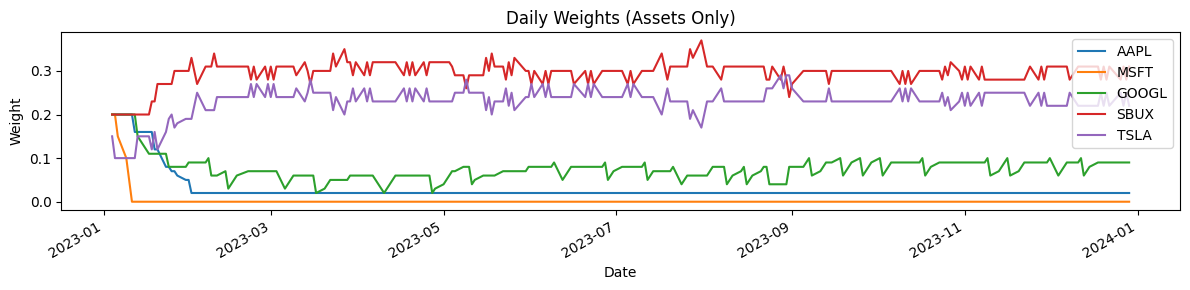

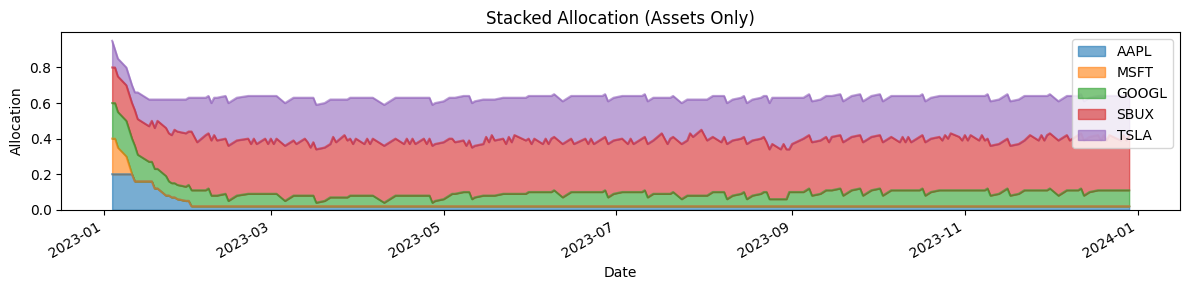

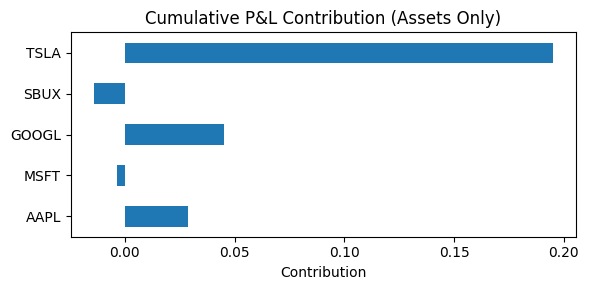

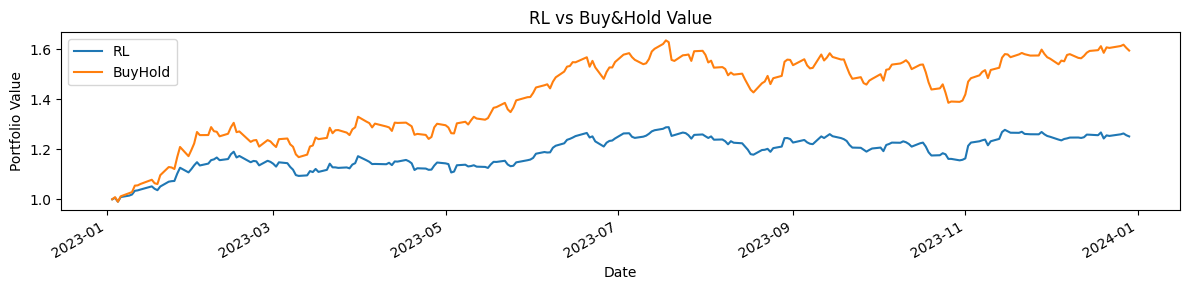

Evaluation completed.

Starting experiment 2
[Ep 10]  val=-0.0058  best=-inf epsilon=0.951
  ↳ new best! checkpointing ensemble
[Ep 20]  val=0.0086  best=-0.0058 epsilon=0.905
  ↳ new best! checkpointing ensemble
[Ep 30]  val=-0.0733  best=0.0086 epsilon=0.860
  ↳ no improvement over last (1/5)
[Ep 40]  val=-0.0125  best=0.0086 epsilon=0.818
  ↳ no improvement over last (2/5)
[Ep 50]  val=-0.0674  best=0.0086 epsilon=0.778
  ↳ no improvement over last (3/5)
[Ep 60]  val=-0.0908  best=0.0086 epsilon=0.740
  ↳ no improvement over last (4/5)
[Ep 70]  val=-0.0222  best=0.0086 epsilon=0.704
  ↳ no improvement over last (5/5)
Early stopping at episode 70 (no improvement for 5 checks)
Training completed.
Evaluating model...
Best simulation metrics:
  Final portfolio value: 1.7062
  Return: 70.62%
  Annualized Sharpe ratio: 2.3013
  Maximum drawdown: 1876.17%



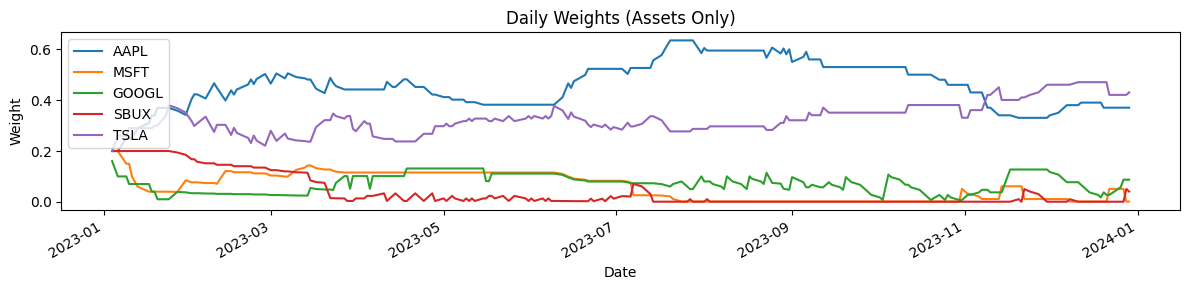

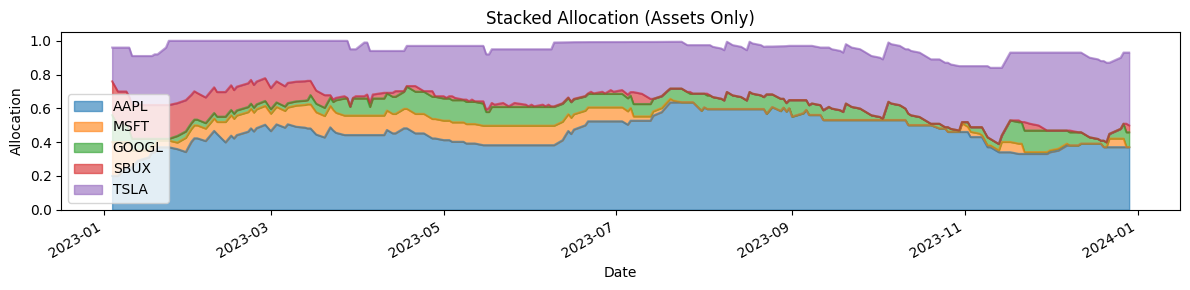

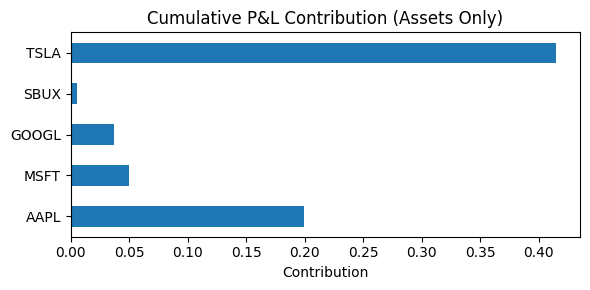

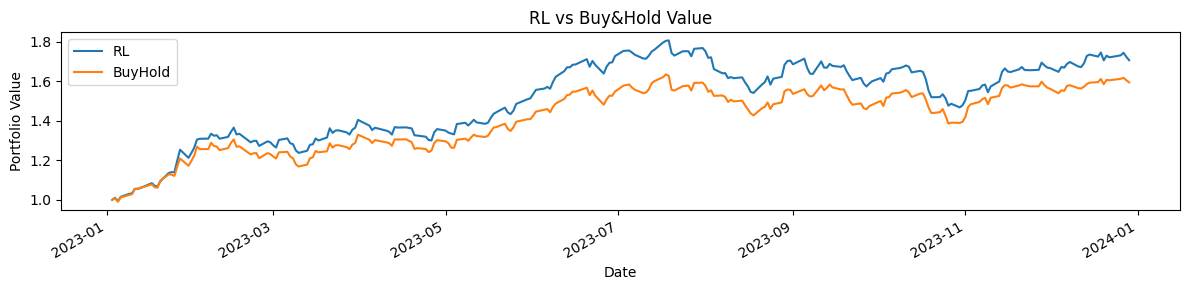

Evaluation completed.

Starting experiment 3
[Ep 10]  val=-0.0978  best=-inf epsilon=0.951
  ↳ new best! checkpointing ensemble
[Ep 20]  val=-0.1317  best=-0.0978 epsilon=0.905
  ↳ no improvement over last (1/5)
[Ep 30]  val=-0.0098  best=-0.0978 epsilon=0.860
  ↳ new best! checkpointing ensemble
[Ep 40]  val=-0.0504  best=-0.0098 epsilon=0.818
  ↳ no improvement over last (1/5)
[Ep 50]  val=-0.0219  best=-0.0098 epsilon=0.778
  ↳ no improvement over last (2/5)
[Ep 60]  val=-0.1321  best=-0.0098 epsilon=0.740
  ↳ no improvement over last (3/5)
[Ep 70]  val=-0.1357  best=-0.0098 epsilon=0.704
  ↳ no improvement over last (4/5)
[Ep 80]  val=-0.1979  best=-0.0098 epsilon=0.670
  ↳ no improvement over last (5/5)
Early stopping at episode 80 (no improvement for 5 checks)
Training completed.
Evaluating model...
Best simulation metrics:
  Final portfolio value: 1.5449
  Return: 54.49%
  Annualized Sharpe ratio: 1.5346
  Maximum drawdown: 2235.90%



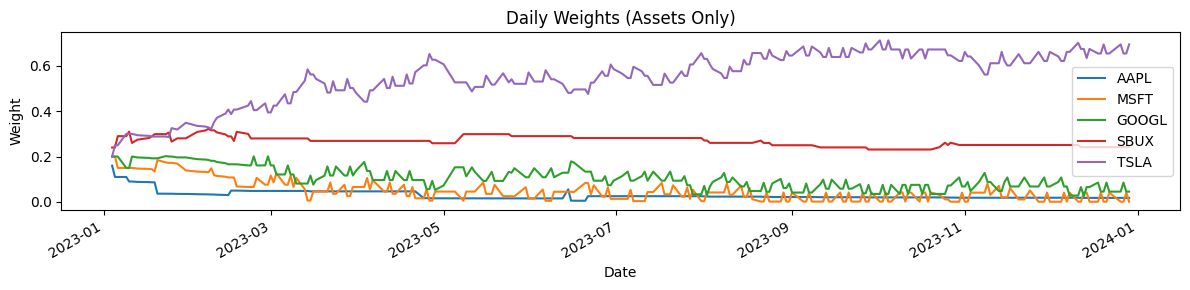

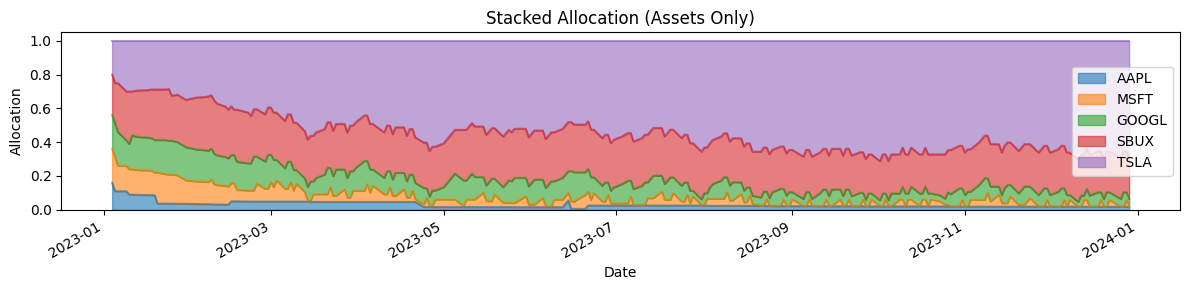

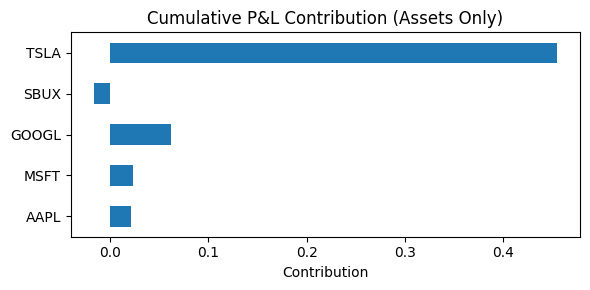

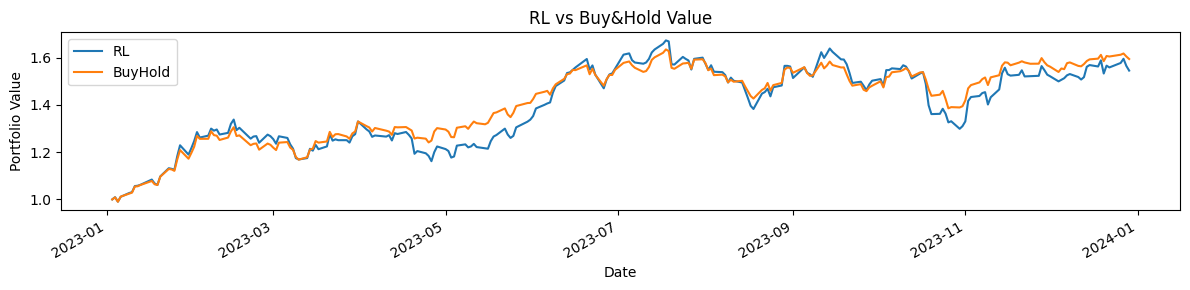

Evaluation completed.

Starting experiment 4
[Ep 10]  val=0.1576  best=-inf epsilon=0.951
  ↳ new best! checkpointing ensemble
[Ep 20]  val=-0.0355  best=0.1576 epsilon=0.905
  ↳ no improvement over last (1/5)
[Ep 30]  val=-0.2272  best=0.1576 epsilon=0.860
  ↳ no improvement over last (2/5)
[Ep 40]  val=-0.0440  best=0.1576 epsilon=0.818
  ↳ no improvement over last (3/5)
[Ep 50]  val=-0.0530  best=0.1576 epsilon=0.778
  ↳ no improvement over last (4/5)
[Ep 60]  val=-0.1592  best=0.1576 epsilon=0.740
  ↳ no improvement over last (5/5)
Early stopping at episode 60 (no improvement for 5 checks)
Training completed.
Evaluating model...
Best simulation metrics:
  Final portfolio value: 1.6620
  Return: 66.20%
  Annualized Sharpe ratio: 2.1552
  Maximum drawdown: 1528.73%



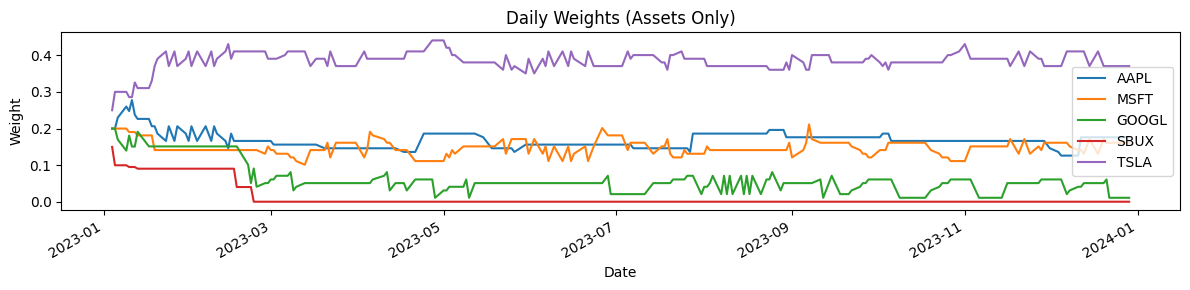

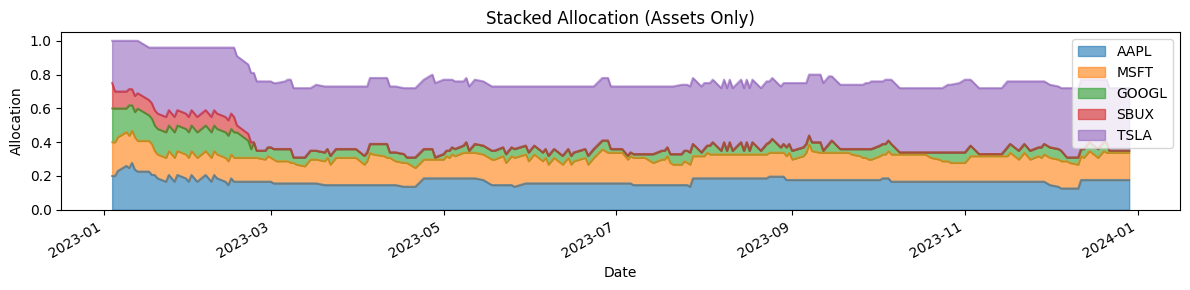

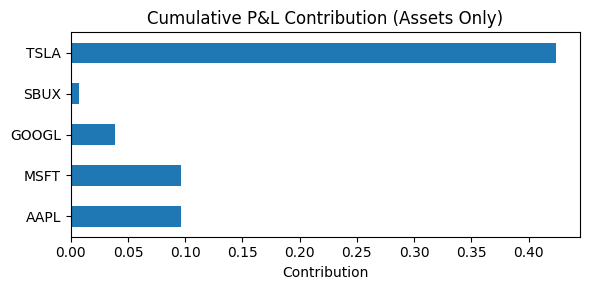

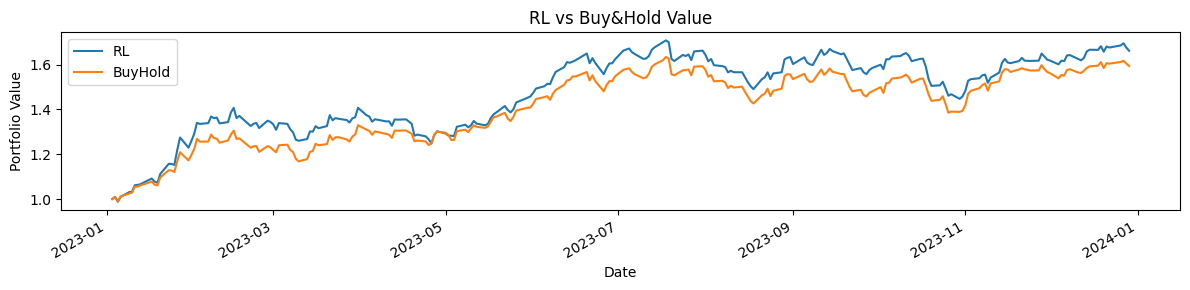

Evaluation completed.

Starting experiment 5
[Ep 10]  val=0.0223  best=-inf epsilon=0.951
  ↳ new best! checkpointing ensemble
[Ep 20]  val=-0.5594  best=0.0223 epsilon=0.905
  ↳ no improvement over last (1/5)
[Ep 30]  val=-0.3768  best=0.0223 epsilon=0.860
  ↳ no improvement over last (2/5)
[Ep 40]  val=-0.0613  best=0.0223 epsilon=0.818
  ↳ no improvement over last (3/5)
[Ep 50]  val=-0.2415  best=0.0223 epsilon=0.778
  ↳ no improvement over last (4/5)
[Ep 60]  val=0.0110  best=0.0223 epsilon=0.740
  ↳ no improvement over last (5/5)
Early stopping at episode 60 (no improvement for 5 checks)
Training completed.
Evaluating model...
Best simulation metrics:
  Final portfolio value: 1.5150
  Return: 51.50%
  Annualized Sharpe ratio: 2.3654
  Maximum drawdown: 1066.62%



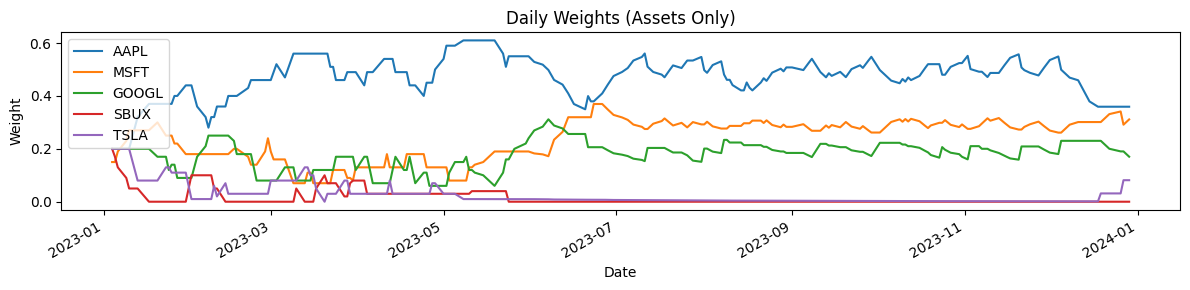

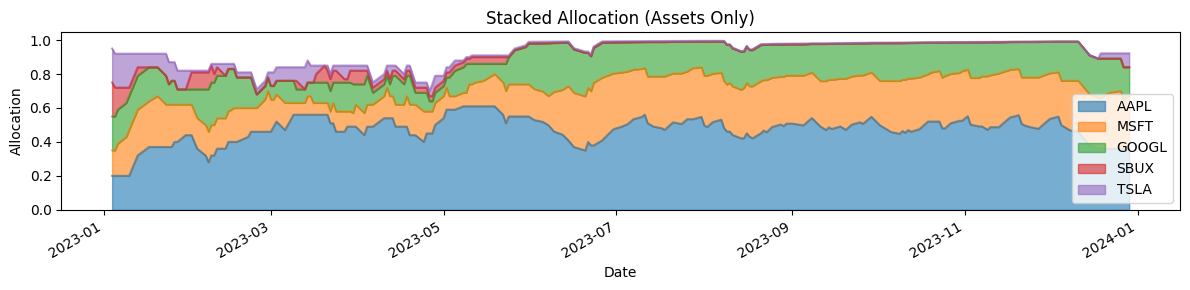

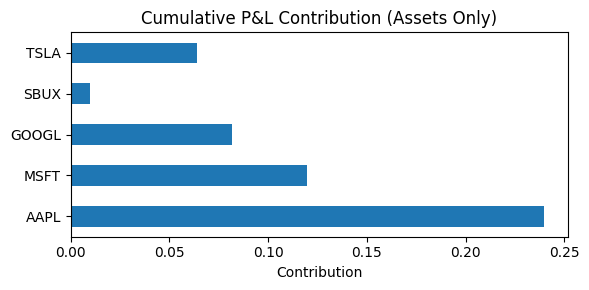

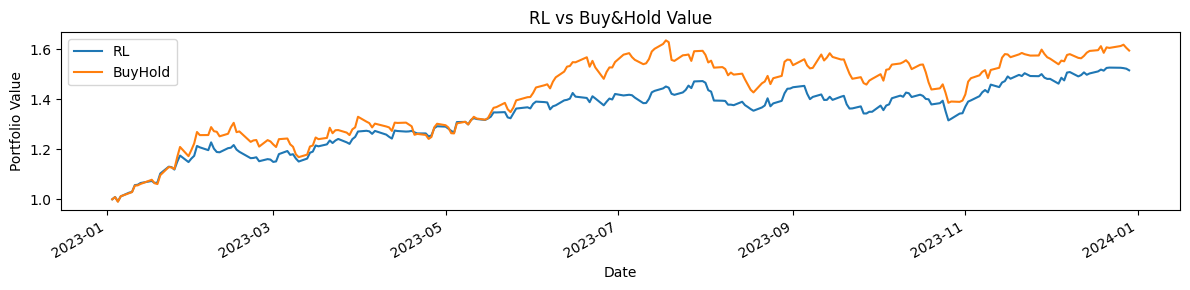

Evaluation completed.

Starting experiment 6
[Ep 10]  val=-0.0508  best=-inf epsilon=0.951
  ↳ new best! checkpointing ensemble
[Ep 20]  val=0.1295  best=-0.0508 epsilon=0.905
  ↳ new best! checkpointing ensemble
[Ep 30]  val=-0.1645  best=0.1295 epsilon=0.860
  ↳ no improvement over last (1/5)
[Ep 40]  val=-0.1037  best=0.1295 epsilon=0.818
  ↳ no improvement over last (2/5)
[Ep 50]  val=-0.0871  best=0.1295 epsilon=0.778
  ↳ no improvement over last (3/5)
[Ep 60]  val=-0.0749  best=0.1295 epsilon=0.740
  ↳ no improvement over last (4/5)
[Ep 70]  val=-0.0626  best=0.1295 epsilon=0.704
  ↳ no improvement over last (5/5)
Early stopping at episode 70 (no improvement for 5 checks)
Training completed.
Evaluating model...
Best simulation metrics:
  Final portfolio value: 1.6998
  Return: 69.98%
  Annualized Sharpe ratio: 2.5610
  Maximum drawdown: 1062.13%



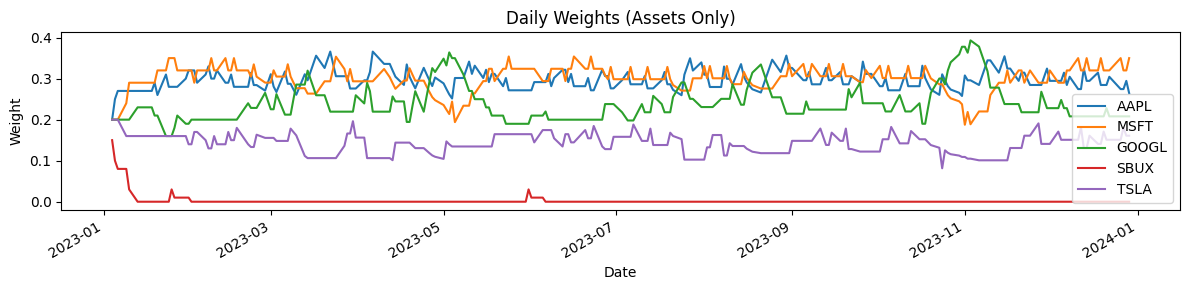

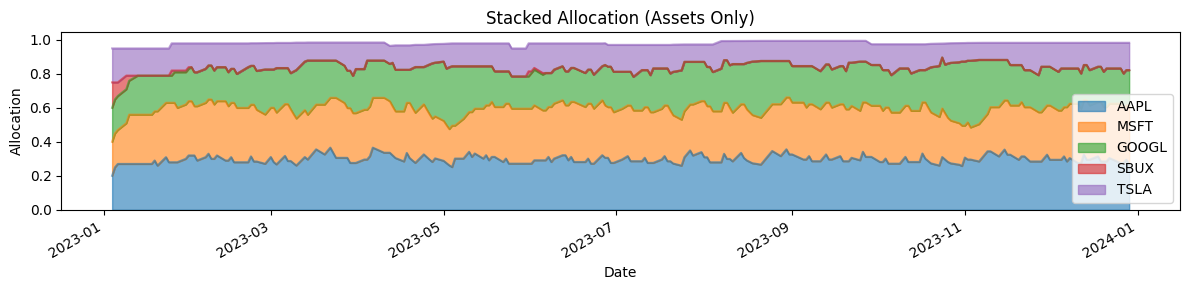

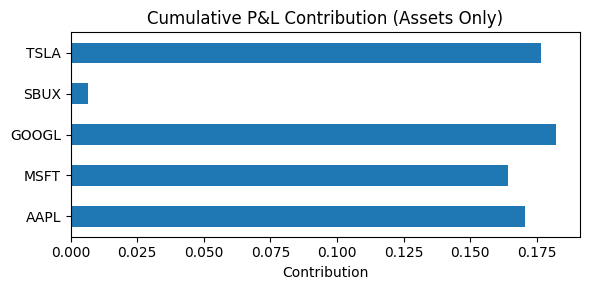

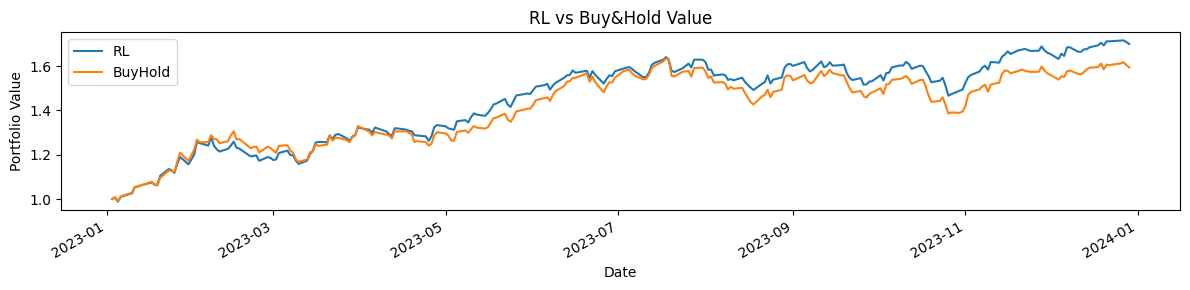

Evaluation completed.

Starting experiment 7
[Ep 10]  val=-0.0264  best=-inf epsilon=0.951
  ↳ new best! checkpointing ensemble
[Ep 20]  val=-0.2779  best=-0.0264 epsilon=0.905
  ↳ no improvement over last (1/5)
[Ep 30]  val=0.1928  best=-0.0264 epsilon=0.860
  ↳ new best! checkpointing ensemble
[Ep 40]  val=0.0515  best=0.1928 epsilon=0.818
  ↳ no improvement over last (1/5)
[Ep 50]  val=0.0002  best=0.1928 epsilon=0.778
  ↳ no improvement over last (2/5)
[Ep 60]  val=-0.1994  best=0.1928 epsilon=0.740
  ↳ no improvement over last (3/5)
[Ep 70]  val=-0.0529  best=0.1928 epsilon=0.704
  ↳ no improvement over last (4/5)
[Ep 80]  val=-0.0480  best=0.1928 epsilon=0.670
  ↳ no improvement over last (5/5)
Early stopping at episode 80 (no improvement for 5 checks)
Training completed.
Evaluating model...
Best simulation metrics:
  Final portfolio value: 1.2921
  Return: 29.21%
  Annualized Sharpe ratio: 1.7286
  Maximum drawdown: 778.45%



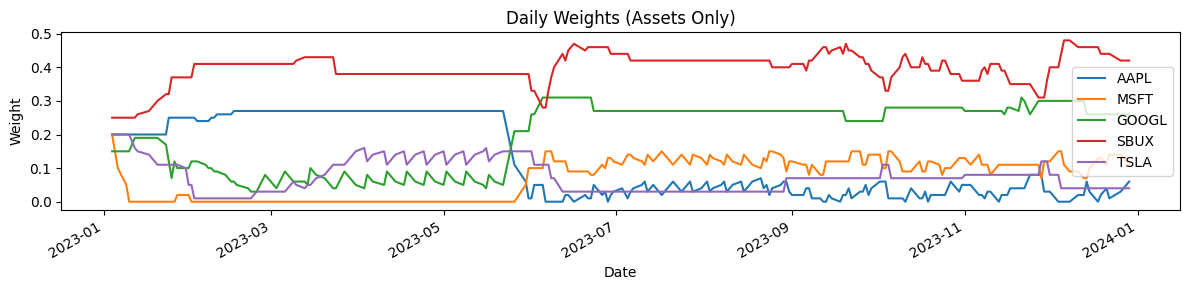

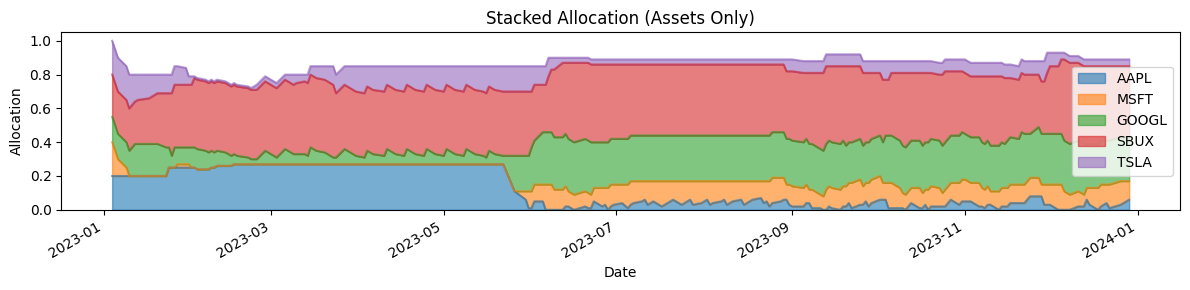

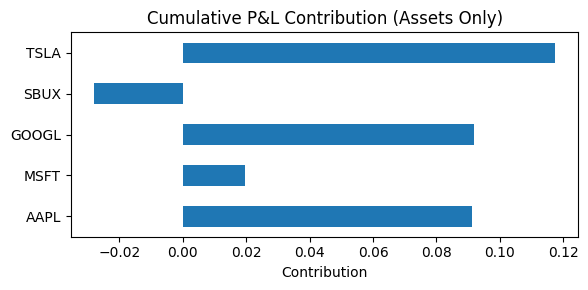

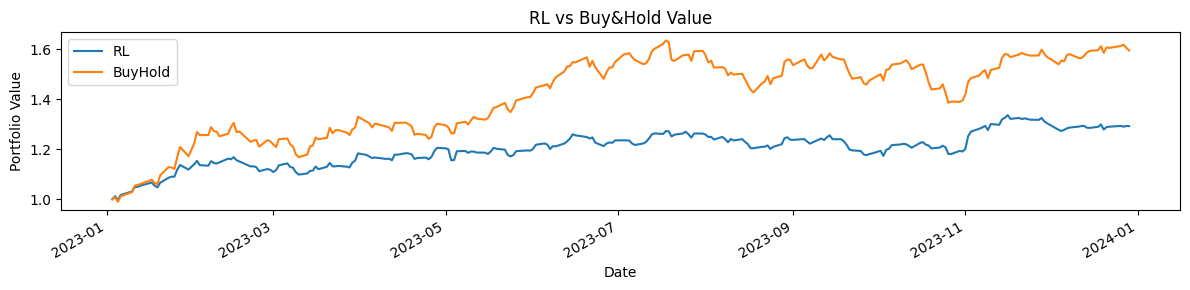

Evaluation completed.

Starting experiment 8
[Ep 10]  val=-0.0889  best=-inf epsilon=0.951
  ↳ new best! checkpointing ensemble
[Ep 20]  val=-0.1869  best=-0.0889 epsilon=0.905
  ↳ no improvement over last (1/5)
[Ep 30]  val=0.0504  best=-0.0889 epsilon=0.860
  ↳ new best! checkpointing ensemble
[Ep 40]  val=-0.1857  best=0.0504 epsilon=0.818
  ↳ no improvement over last (1/5)
[Ep 50]  val=-0.0008  best=0.0504 epsilon=0.778
  ↳ no improvement over last (2/5)
[Ep 60]  val=-0.0025  best=0.0504 epsilon=0.740
  ↳ no improvement over last (3/5)
[Ep 70]  val=-0.0363  best=0.0504 epsilon=0.704
  ↳ no improvement over last (4/5)
[Ep 80]  val=0.0339  best=0.0504 epsilon=0.670
  ↳ no improvement over last (5/5)
Early stopping at episode 80 (no improvement for 5 checks)
Training completed.
Evaluating model...
Best simulation metrics:
  Final portfolio value: 1.3155
  Return: 31.55%
  Annualized Sharpe ratio: 1.7707
  Maximum drawdown: 794.72%



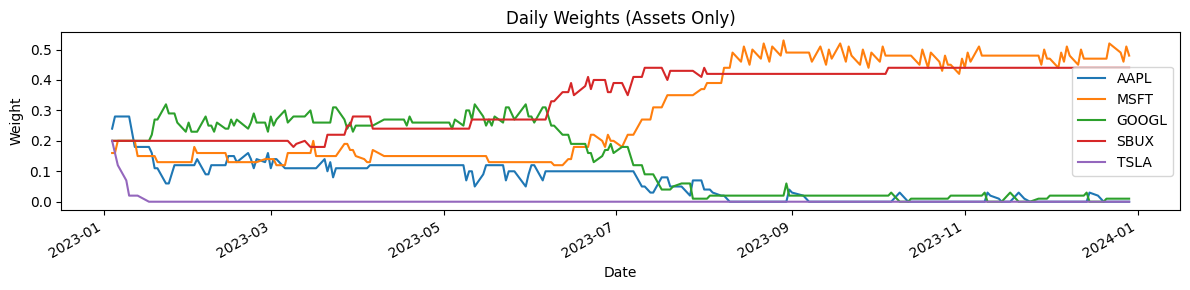

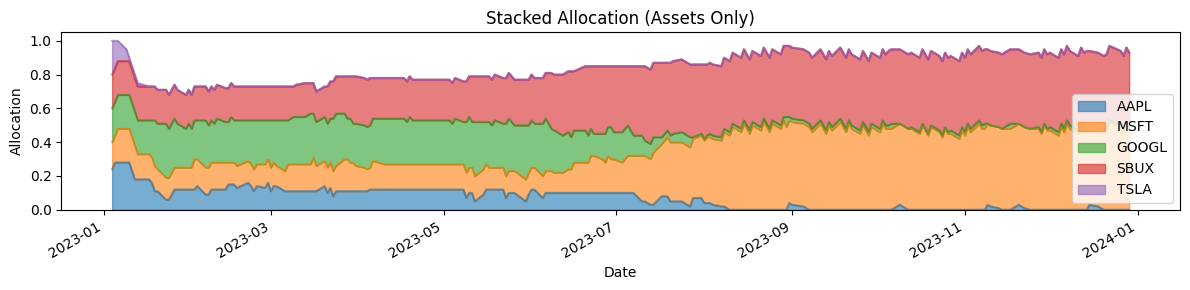

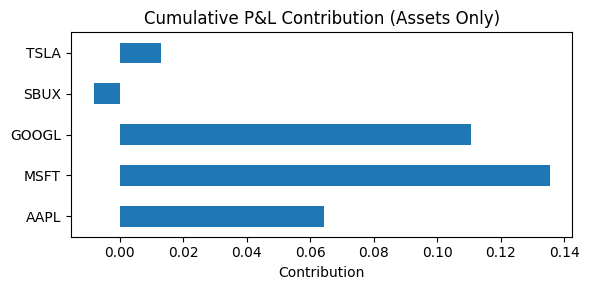

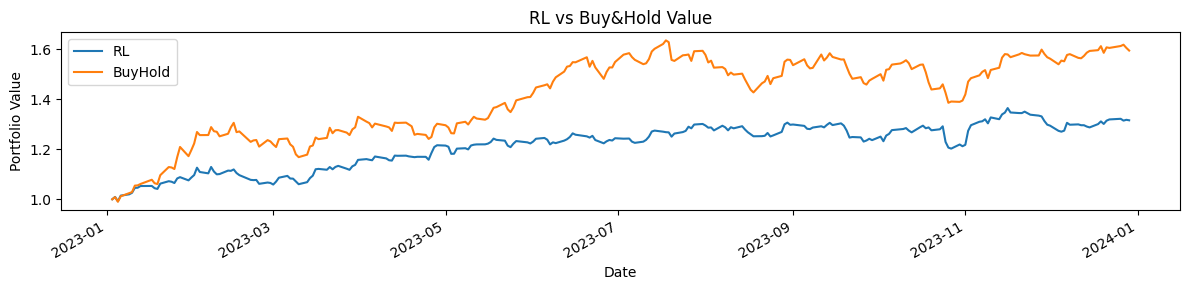

Evaluation completed.

Starting experiment 9
[Ep 10]  val=-0.0962  best=-inf epsilon=0.951
  ↳ new best! checkpointing ensemble
[Ep 20]  val=-0.1630  best=-0.0962 epsilon=0.905
  ↳ no improvement over last (1/5)
[Ep 30]  val=-0.1128  best=-0.0962 epsilon=0.860
  ↳ no improvement over last (2/5)
[Ep 40]  val=-0.1782  best=-0.0962 epsilon=0.818
  ↳ no improvement over last (3/5)
[Ep 50]  val=-0.0324  best=-0.0962 epsilon=0.778
  ↳ new best! checkpointing ensemble
[Ep 60]  val=-0.0243  best=-0.0324 epsilon=0.740
  ↳ new best! checkpointing ensemble
[Ep 70]  val=0.0714  best=-0.0243 epsilon=0.704
  ↳ new best! checkpointing ensemble
[Ep 80]  val=0.0268  best=0.0714 epsilon=0.670
  ↳ no improvement over last (1/5)
[Ep 90]  val=0.0438  best=0.0714 epsilon=0.637
  ↳ no improvement over last (2/5)
[Ep 100]  val=-0.0204  best=0.0714 epsilon=0.606
  ↳ no improvement over last (3/5)
[Ep 110]  val=-0.0418  best=0.0714 epsilon=0.576
  ↳ no improvement over last (4/5)
[Ep 120]  val=0.0137  best=0.07

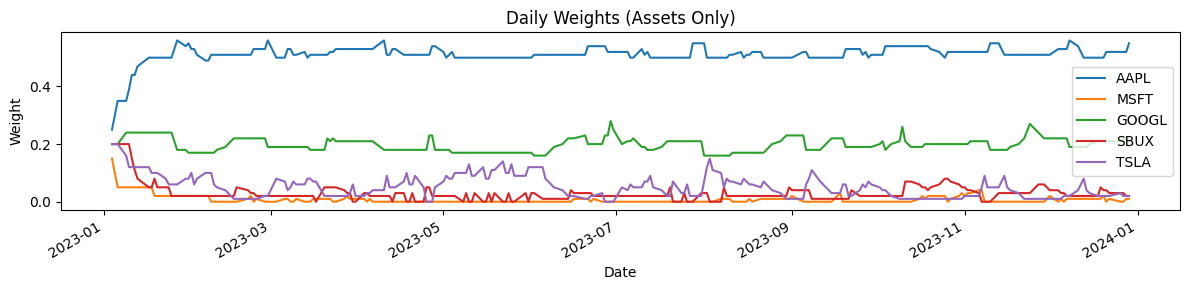

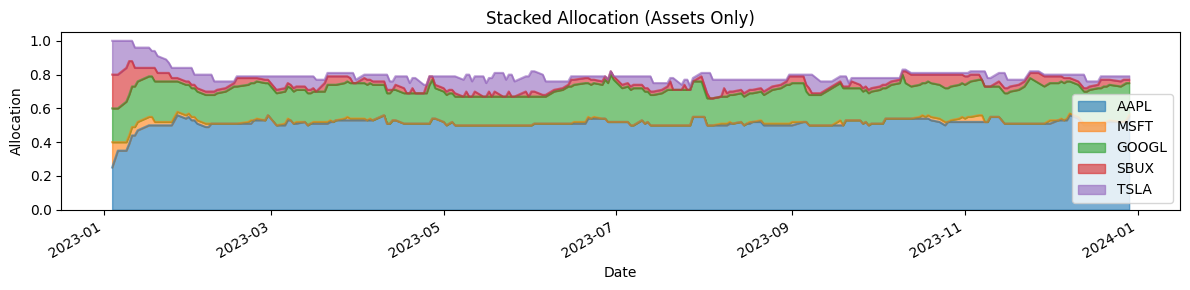

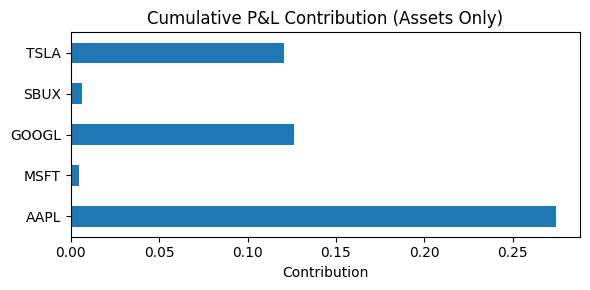

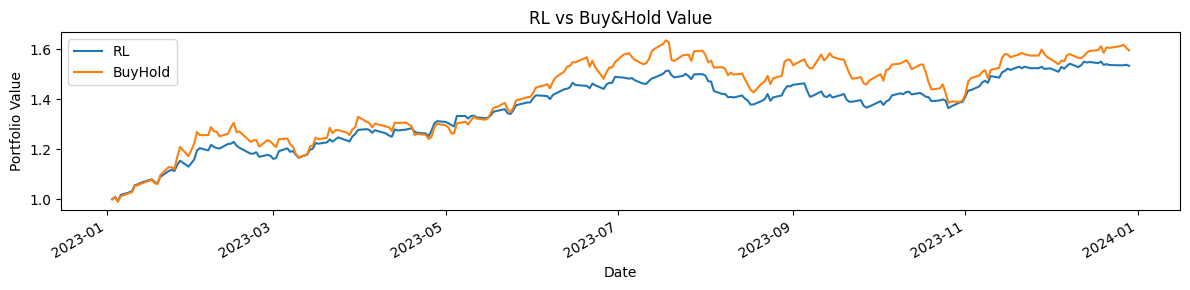

Evaluation completed.

Starting experiment 10
[Ep 10]  val=-0.2845  best=-inf epsilon=0.951
  ↳ new best! checkpointing ensemble
[Ep 20]  val=0.1768  best=-0.2845 epsilon=0.905
  ↳ new best! checkpointing ensemble
[Ep 30]  val=-0.0811  best=0.1768 epsilon=0.860
  ↳ no improvement over last (1/5)
[Ep 40]  val=-0.0635  best=0.1768 epsilon=0.818
  ↳ no improvement over last (2/5)
[Ep 50]  val=-0.0554  best=0.1768 epsilon=0.778
  ↳ no improvement over last (3/5)
[Ep 60]  val=-0.2311  best=0.1768 epsilon=0.740
  ↳ no improvement over last (4/5)
[Ep 70]  val=-0.2188  best=0.1768 epsilon=0.704
  ↳ no improvement over last (5/5)
Early stopping at episode 70 (no improvement for 5 checks)
Training completed.
Evaluating model...
Best simulation metrics:
  Final portfolio value: 1.6510
  Return: 65.10%
  Annualized Sharpe ratio: 1.9876
  Maximum drawdown: 1826.25%



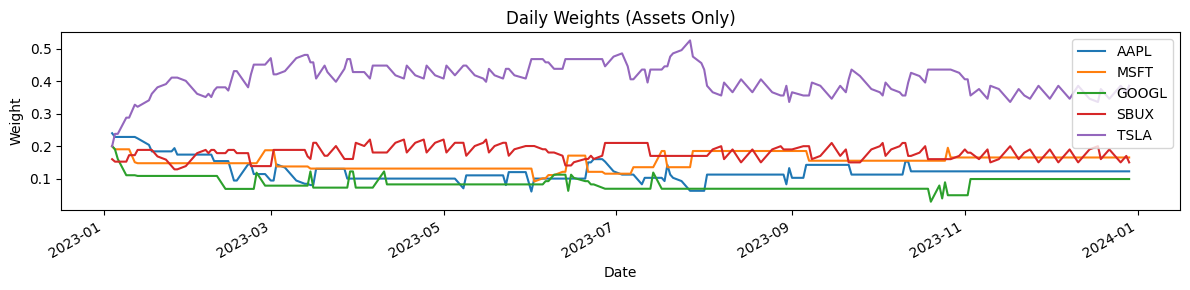

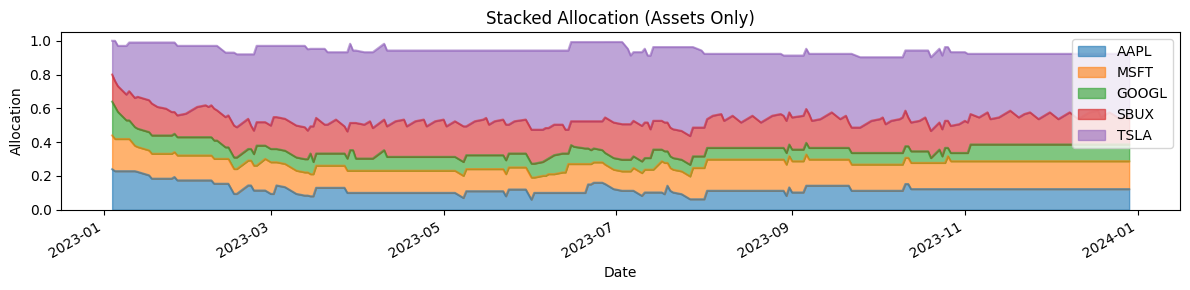

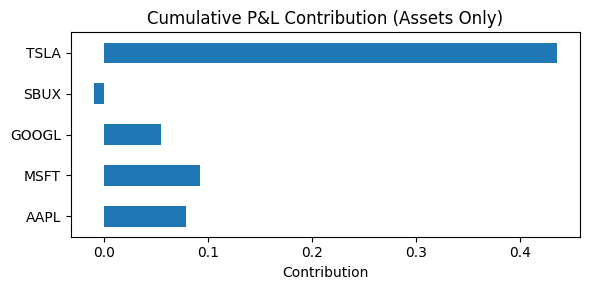

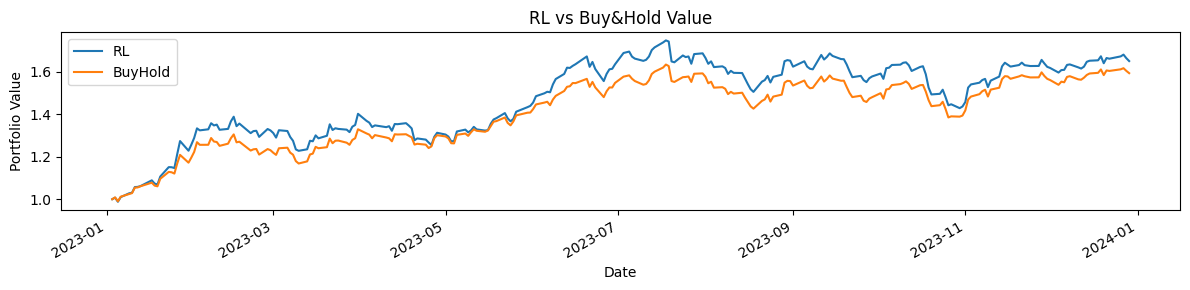

Evaluation completed.

Final evaluation results:
    Final portfolio value: 1.7062
    Final return: 70.62%
    Annualized Sharpe ratio: 2.3013
    Maximum drawdown: 1876.17%

Baseline portfolio value: 1.5939
  Return: 59.39%
-----------------BEST FIGURES-------------


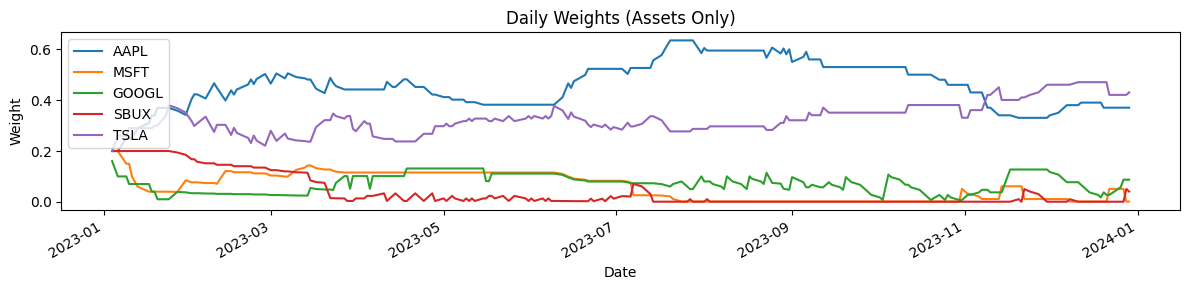

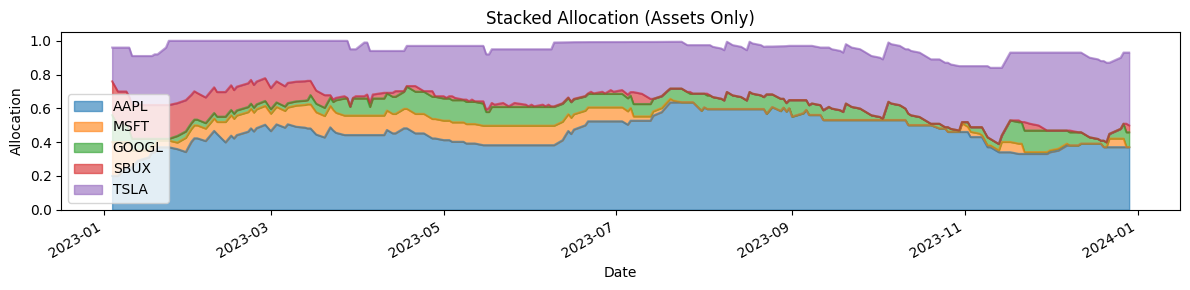

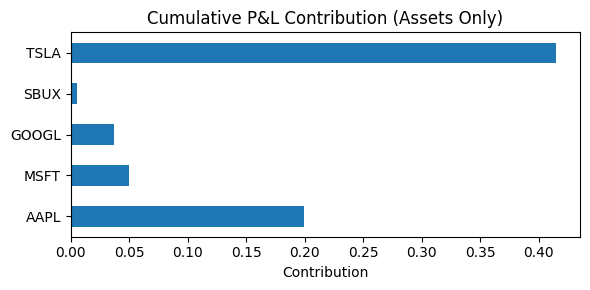

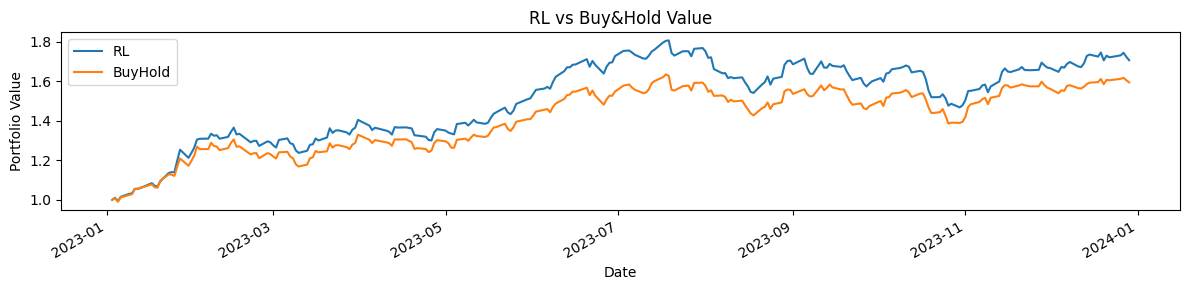

In [56]:
def run_experiments(n_experiments=5, **train_params):
    """
    Runs the entire training process for n experiments and prints a summary.
    Returns a list of (trained_ensemble, best_val_reward) tuples from each experiment.
    """
    trained_models = []
    results = {
        'final_portfolio_value': -np.inf,
        'final_return': 0.0,
        'sharpe_ratio': 0.0,
        'max_drawdown': 0.0,
    }
    
    results['baseline_values'], results['baseline_return'] = evaluate_baseline(test_prices)
    
    for i in range(n_experiments):
        intermediate_results = {}
        intermediate_results['baseline_values'], intermediate_results['baseline_return'] = results['baseline_values'], results['baseline_return']
        print("Starting experiment", i+1)
        trained_ensemble = train_agent(**train_params)                                                                                                                                                                                                                                              
        trained_models.append(trained_ensemble)
        print("Evaluating model...")
        agent_values, agent_metrics, all_run_metrics, best_weights, contrib_series = evaluate_policy(test_prices, trained_ensemble, initial_state, 10)
        intermediate_results['final_portfolio_value'], intermediate_results['final_return'], intermediate_results['sharpe_ratio'], intermediate_results['max_drawdown'] = agent_metrics['final_portfolio_value'], agent_metrics['final_return'], agent_metrics['sharpe_ratio'], agent_metrics['max_drawdown']
        intermediate_results['agent_values'] = agent_values
        intermediate_results['agent_weights'] = best_weights
        intermediate_results['contrib_series'] = contrib_series
        plot(intermediate_results, save=False)
        if results['final_portfolio_value'] < agent_metrics['final_portfolio_value']:
            results = intermediate_results
        print("Evaluation completed.")
        print() 
    return trained_models, results

models, results = run_experiments(n_experiments=10, episodes=200, gamma=0.99, batch_size=128)
    

print("Final evaluation results:")
print(f"    Final portfolio value: {results['final_portfolio_value']:.4f}")
print(f"    Final return: {results['final_return']:.2f}%")
print(f"    Annualized Sharpe ratio: {results['sharpe_ratio']:.4f}")
print(f"    Maximum drawdown: {results['max_drawdown']:.2%}")
print()
print(f"Baseline portfolio value: {results['baseline_values'][-1]:.4f}")
print(f"  Return: {results['baseline_return']:.2f}%")
print("-----------------BEST FIGURES-------------")
plot(results, save=True)